## Description of the task and dataset

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#input data initialization
train_data_path = '../cases/data/scoring/scoring_train.csv'
test_data_path = '../cases/data/scoring/scoring_test.csv'
df = pd.read_csv(train_data_path)
df.head(10)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
5,5,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,0
6,6,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0,0
7,7,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,0
8,8,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN,0
9,9,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,0


In [2]:
## Baseline model

from fedot.api.main import Fedot

#task selection, initialisation of the framework
baseline_model = Fedot(problem='classification')

#fit model without optimisation - single XGBoost node is used 
baseline_model.fit(features=train_data_path, target='target', predefined_model='xgboost')

#evaluate the prediction with test data
baseline_model.predict(features=test_data_path)

#evaluate quality metric for the test sample
baseline_metrics = baseline_model.get_metrics()
print(baseline_metrics)

{'roc_auc': 0.827, 'f1': 0.32508833922261476}


## FEDOT AutoML for classification

In [3]:
# new instance to be used as AutoML tool
auto_model = Fedot(problem='classification', seed = 42)

In [4]:
#run of the AutoML-based model generation
pipeline = auto_model.fit(features=train_data_path, target='target')

light_tun preset is used. Parameters tuning: True. Number of candidate models: ['logit', 'lda', 'qda', 'dt', 'rf', 'knn', 'xgboost', 'bernb', 'direct_data_model', 'pca_data_model']. Composing time limit: 0:02:00
Model composition started
Composition time: 1.067 min
Algorithm was terminated due to processing time limit
Hyperparameters tuning started
Tuning completed because of the time limit reached
Tuning completed because of the time limit reached
Model composition finished


In [5]:
prediction = auto_model.predict(features=test_data_path)
auto_metrics = auto_model.get_metrics()
print(auto_metrics)

{'roc_auc': 0.841, 'f1': 0.37182448036951504}


In [7]:
#comparison with the manual pipeline

print('Baseline', round(baseline_metrics['roc_auc'], 3))
print('AutoML solution', round(auto_metrics['roc_auc'], 3))

pipeline = auto_model.current_model

Baseline 0.827
AutoML solution 0.841


## FEDOT AutoML for the time series forecasting

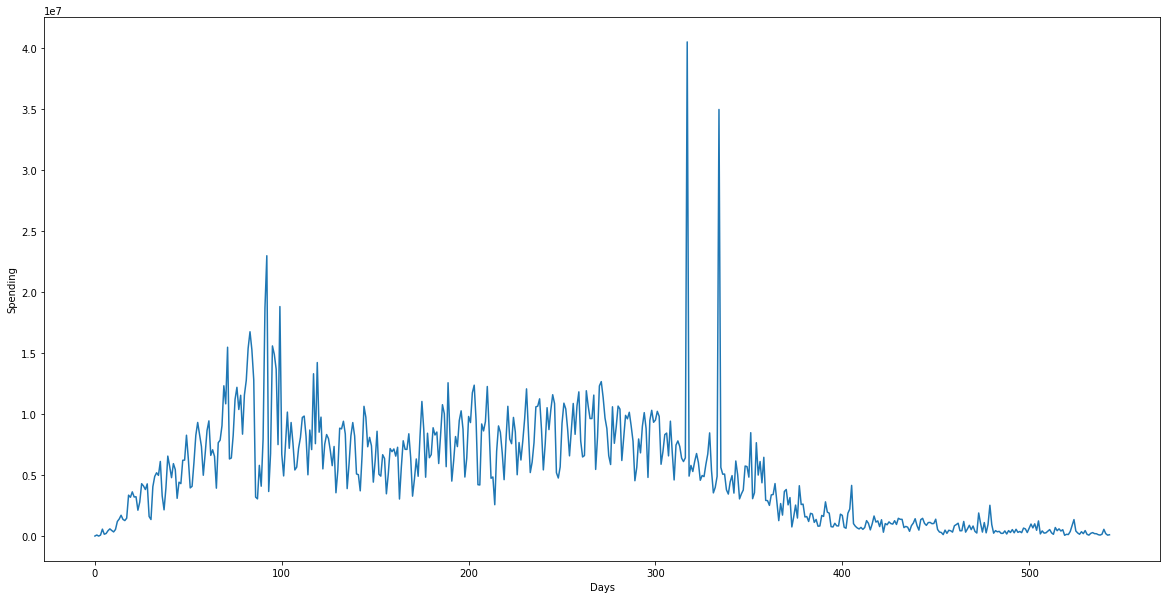

In [8]:
#read and plot the time series data

import matplotlib.pyplot as plt
import pandas as pd

train_data_path = './jupyter_media/intro/salaries.csv'
train_data = pd.read_csv(train_data_path)

plt.figure(figsize=(20,10))
plt.plot(train_data['target'])
plt.xlabel('Days')
plt.ylabel('Spending')
plt.show()

In [9]:
from fedot.api.main import Fedot

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting')

light preset is used. Parameters tuning: False. Number of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'knnreg', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'trend_data_model', 'residual_data_model']. Composing time limit: 0:02:00
Model composition started
Composition time: 1.9 min
Algorithm was terminated due to processing time limit
Model composition finished


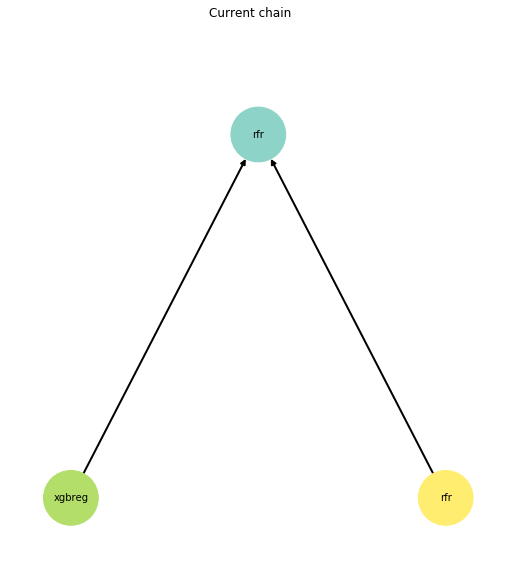

In [10]:
#run AutoML model design in the same way
chain = model.fit(features=train_data_path, target='target')
chain.show()

# use model to obtain forecast

ts_forecast = model.forecast(pre_history=train_data_path, forecast_length = 30)

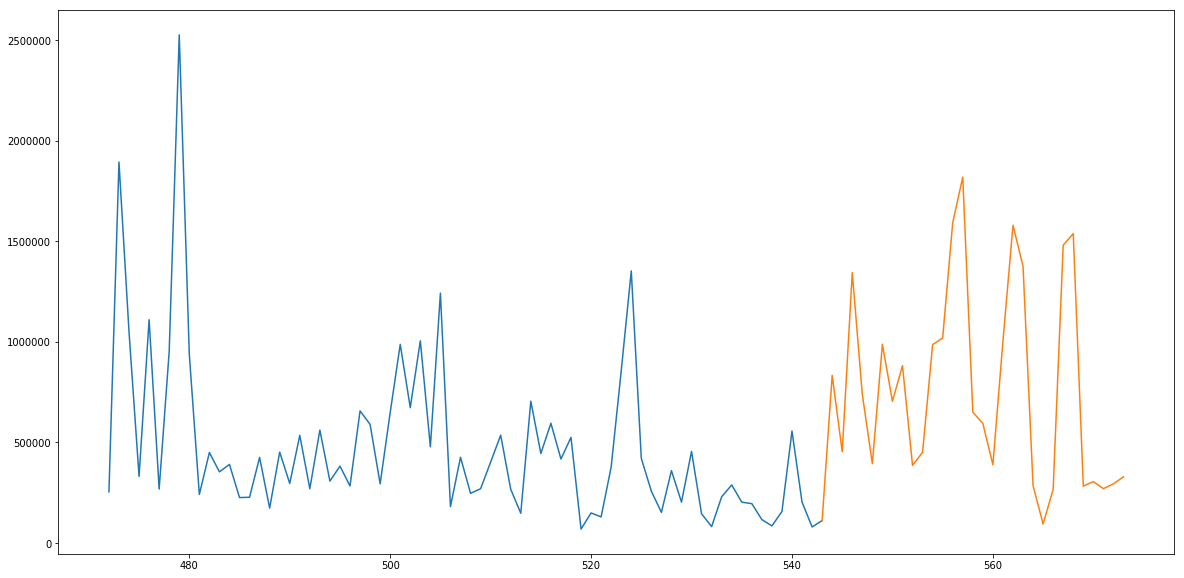

In [11]:
#plot forecasting result
model.plot_prediction()